In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
import sys, os
sys.path.append(os.path.abspath("../src"))


In [3]:
from setup_nltk import download_nltk_resources

download_nltk_resources()

from preprocessing import preprocess_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\keita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\keita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\keita\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\keita\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\keita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
ds = load_dataset("FredZhang7/all-scam-spam")
df = ds["train"].to_pandas()

# Missing values

In [13]:
missing_counts = df.isnull().sum()
missing_counts


text          0
is_spam       0
clean_text    0
dtype: int64

# Preprocessing

In [5]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [6]:
df["clean_text"]

0        new sequenc window date wed aug chri garrigu m...
1        zzzzteana alexand martin post tasso papadopoul...
2        zzzzteana moscow bomber man threaten explos mo...
3        irr klez viru wont die klez viru wont die alre...
4        zzzzteana noth like mama use make ad cream spa...
                               ...                        
42614    какой у тебя любимый цвет фантастический единорог
42615                        что ты сегодня ел чудопеченье
42616               что ты думаешь о спорте секретный ключ
42617        какой твой любимый вид спорта волшебный ковер
42618                             ты умеешь петь чудоптица
Name: clean_text, Length: 42619, dtype: object

In [ ]:
df.to_csv("../data/clean_data.csv", index=False)

# EDA

In [4]:
df = pd.read_csv("../data/clean_data.csv")

In [10]:
print("Text length distribution:")
df['text_length'] = df['clean_text'].apply(lambda x: len(str(x)))
df['text_length'].describe()

Text length distribution:


count     42619.000000
mean        873.696028
std        2917.824791
min           1.000000
25%         128.000000
50%         347.000000
75%         824.000000
max      200506.000000
Name: text_length, dtype: float64

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Supponiamo che tu abbia già il testo pulito in df["clean_text"]
texts = df["clean_text"].dropna().astype(str)

# === CO-OCCURRENCE MATRIX ===
vectorizer = CountVectorizer(stop_words="english", max_features=1000)
X = vectorizer.fit_transform(texts)

# Convert to DataFrame (feature names = parole)
cooccurrence_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Calcola co-occorrenze come matrice di correlazione (approssimata)
cooccurrence_matrix = cooccurrence_df.T @ cooccurrence_df

# Visualizza le prime 10 parole più co-occorrenti con una parola specifica
focus_word = "money"  # cambia se vuoi
if focus_word in cooccurrence_matrix.columns:
    print(f"🔗 Parole più co-occorenti con '{focus_word}':")
    display(cooccurrence_matrix[focus_word].sort_values(ascending=False)[1:11])
else:
    print(f"❌ La parola '{focus_word}' non è tra le top features selezionate.")

c:\Users\keita\AppData\Local\pypoetry\Cache\virtualenvs\tm4scam-N6vyaz1K-py3.12\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127781 (\N{WHITE SUN BEHIND CLOUD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


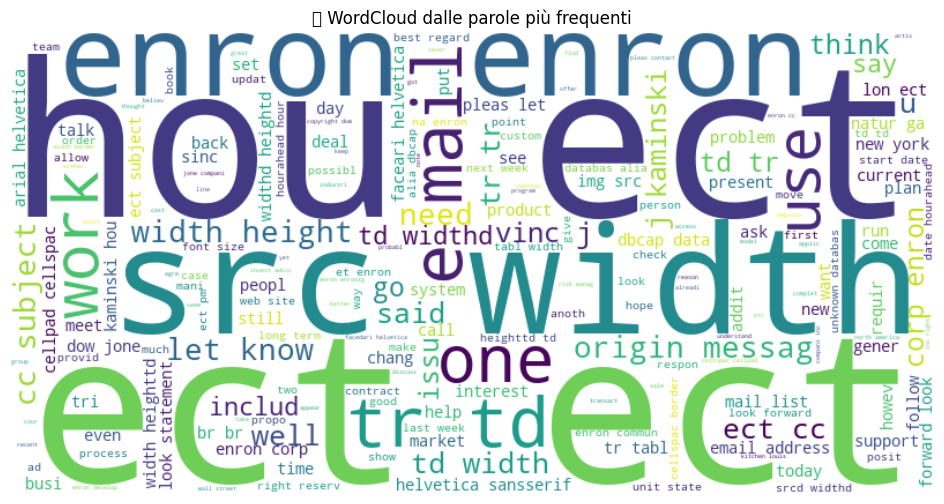

In [ ]:
# Unisci tutti i testi in un'unica stringa
all_text = " ".join(df["clean_text"].dropna().astype(str).tolist())

# Crea la wordcloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200,
    colormap="viridis"
).generate(all_text)

# Mostra la WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud dalle parole più frequenti")
plt.show()


is_spam
0    25187
1    17432
Name: count, dtype: int64


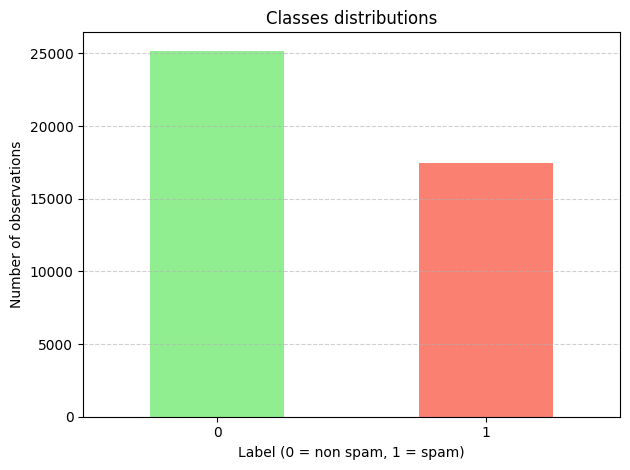

In [8]:
label_counts = df["is_spam"].value_counts()

print(label_counts)

label_counts.plot(kind="bar", color=["lightgreen", "salmon"])
plt.xticks(rotation=0)
plt.title("Classes distributions")
plt.xlabel("Label (0 = non spam, 1 = spam)")
plt.ylabel("Number of observations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [13]:
df["is_spam"].unique()

array([0, 1])

## Split train and test

In [11]:
df.dropna(inplace=True)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["is_spam"], test_size=0.2, stratify=df["is_spam"])


In [15]:
train_df = pd.DataFrame({"text": X_train, "label": y_train})
test_df = pd.DataFrame({"text": X_test, "label": y_test})
train_df.to_csv("../data/splits/train.csv", index=False)
test_df.to_csv("../data/splits/test.csv", index=False)

# Representation